# Project 1 - Music Recomender

---

- Jack Null
- WFU Email Address: nulljw23@wfu.edu
- Submission Date: 02/09/2024

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

!pip install surprise
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162677 sha256=0a50fda1f65fcc96fde008ffdb209c9a05cccd2ff3560ee52a88404fd0edad6f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## Load in DataFrames

In [3]:
column_names = ['user_id', 'song_id', 'play_count']

kaggle_visible_evaluation_triplets = pd.read_csv("/content/kaggle_visible_evaluation_triplets.txt", sep='\t', names=column_names)
kaggle_visible_evaluation_triplets.head()

,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [4]:
unique_tracks = pd.read_csv('unique_tracks.txt',
                       sep='<SEP>', names=['track_id','song_id','artist_name','song'], engine='python')
unique_tracks.head()

,track_id,song_id,artist_name,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [5]:
unique_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   track_id     1000000 non-null  object
 1   song_id      1000000 non-null  object
 2   artist_name  1000000 non-null  object
 3   song         999985 non-null   object
dtypes: object(4)
memory usage: 30.5+ MB


# Query to find songs

In [6]:
unique_tracks.query('artist_name.str.lower() == "u2"').head(n=5)

,track_id,song_id,artist_name,song
10792,TRMFFUD128C719699C,SOMVMXY12A6310E207,U2,Twilight
20812,TRMTMEO128F92CFD60,SOBAQTV12A8C142277,U2,Sunday Bloody Sunday
21373,TRMTZIE128C719698E,SOVBWVW1288D3EA3DB,U2,With Or Without You
34504,TRMXCHV128F92F965C,SORGTJH12D02199113,U2,Magnificent
35873,TRMKGBD128F42595D2,SOCUYNI12A8AE467AD,U2,I Threw A Brick Through A Window


# Now, I upload an Excel file with my favorite songs and favorite songs from a friend

## Upload Excel document of my favorite songs with a peer's favorite songs

In [7]:
my_songs_df = pd.read_excel("/content/Song List Project 1.xlsx")
my_songs_df.head()

,user_id,song_id,play_count
0,JACK N,SOXKWED12AF72A9043,10
1,JACK N,SONGABP12A8C1442D4,10
2,JACK N,SOUYCCS12AB01804F2,10
3,JACK N,SOSGFTO12AB017DB37,10
4,JACK N,SOEHVLQ12A8C134E88,10


# Append this dataset to my user, song, playcount data.

In [8]:
songs_df = pd.concat([kaggle_visible_evaluation_triplets, my_songs_df], axis=0)
songs_df.head()

,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


## Merge songs DataFrame and the unique_tracks DataFrame

In [9]:
merged_df = pd.merge(songs_df, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.head()

,user_id,song_id,play_count,track_id,artist_name,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero


# EDA

## What are the top 20 played songs in the dataset?

In [10]:
popular_songs = merged_df.groupby('song')['play_count'].sum().nlargest(20)
popular_songs = pd.DataFrame(popular_songs)
popular_songs = popular_songs.reset_index()

In [11]:
popular_songs.head()

,song,play_count
0,You're The One,35738
1,Undo,33179
2,Revelry,24359
3,Sehr kosmisch,19454
4,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115


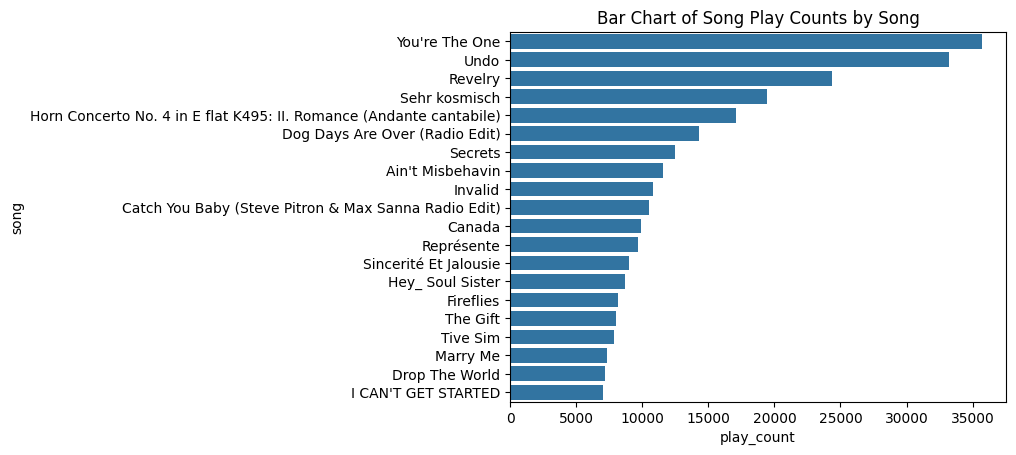

In [18]:
sns.barplot(popular_songs, x='play_count', y='song').set(title='Bar Chart of Song Play Counts by Song')
plt.show()

## Which users listen the most?

In [20]:
top_users = merged_df.groupby('user_id')['play_count'].sum().nlargest(20)
top_users = pd.DataFrame(top_users)
top_users = top_users.reset_index()

In [21]:
top_users.head()

,user_id,play_count
0,090b841eaf56d343a26625c2c6d08b823927bc4f,1305
1,938c2632d43eeadb8a83a7cc254d014f9cea6afe,1267
2,1c5aa998482a40abfd020759e7d757eb6c510e72,1200
3,c6150292374fb1dad89982367b3245dd5004c718,1192
4,5a9375e46a7e9b869058c7bc0e820e00d77f3e0b,1184


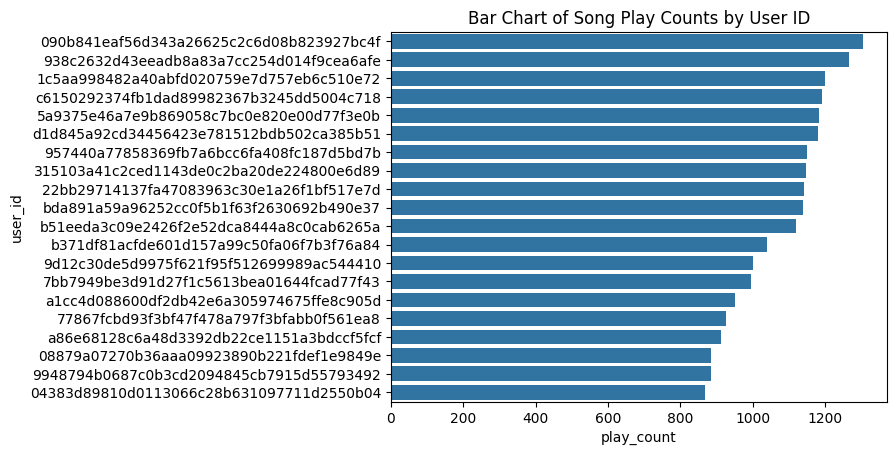

In [22]:
sns.barplot(top_users, y='user_id', x='play_count').set(title='Bar Chart of Song Play Counts by User ID')
plt.show()

## How many plays does the average user have?

In [23]:
average_plays = merged_df['play_count'].mean()
average_plays

3.1872431429550097

## Who are the most popular artists?

In [24]:
top_artists = merged_df.groupby('artist_name')['play_count'].sum().nlargest(20)
top_artists = pd.DataFrame(top_artists )
top_artists = top_artists.reset_index()

In [25]:
top_artists.head()

,artist_name,play_count
0,Kings Of Leon,35857
1,Dwight Yoakam,35688
2,Björk,35210
3,Coldplay,32135
4,Florence + The Machine,28224


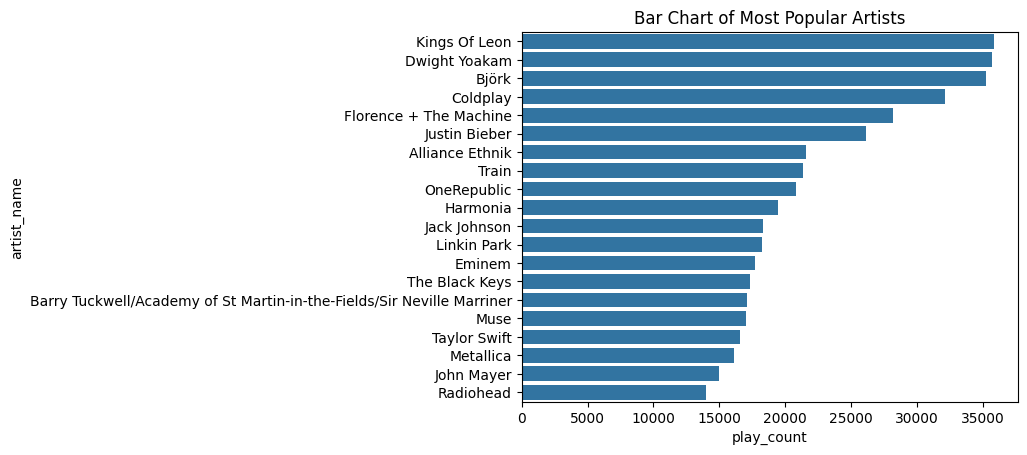

In [26]:
sns.barplot(top_artists, y='artist_name', x='play_count').set(title='Bar Chart of Most Popular Artists')
plt.show()

## How many unique users are there in the dataset?

In [27]:
print(f"No. of unique users: {merged_df['user_id'].nunique()}")

No. of unique users: 110001


## How many unique songs are there?

In [28]:
print(f"No. of unique songs: {merged_df['song_id'].nunique()}")

No. of unique songs: 163220


## How many unique play counts are there?

In [29]:
print(f"No. of unique play counts: {merged_df['play_count'].nunique()}")

No. of unique play counts: 299


## Next, Preprocess the data by binning it

In [30]:
bins = [1, 2, 3, 4, 5,6,7,8,9,10, float('inf')]
labels = [1, 2, 3, 4, 5,6,7,8,9,10]

merged_df['play_count_binned'] = pd.cut(merged_df['play_count'], bins=bins, labels=labels, right=False)
merged_df['play_count_binned'].value_counts()

1     839136
2     213712
3      95726
10     91054
5      73542
4      55158
6      31902
7      22317
8      16179
9      12227
Name: play_count_binned, dtype: int64

# Create a baseline recommendation

In [31]:
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)
# Split the dataset into training and test set
trainset, testset = train_test_split(data, test_size=0.3)
trainset

In [40]:
from surprise import BaselineOnly
# Define and train the BaselineOnly model
print("Evaluating Global Mean Baseline:")
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 5,
               'reg_i': 5}  # You can adjust these parameters
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)
# Predict ratings for the testset
predictions_global = algo_global.test(testset)
# Compute and print RMSE
rmse_global = accuracy.rmse(predictions_global)
# Compute and print MAE
mae_global = accuracy.mae(predictions_global)

Evaluating Global Mean Baseline:
Estimating biases using als...
RMSE: 2.2817
MAE:  1.6130


In [41]:
# Define and evaluate the user mean baseline
print("Evaluating User Mean Baseline:\n")
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 5,     # Regular user regularization
    'reg_i': 100    # High item regularization to diminish item bias
}

#algo_user = BaselineOnly(bsl_options=bsl_options)
algo_user = BaselineOnly(bsl_options=bsl_options)
algo_user.fit(trainset)
# Predict ratings for the testset
predictions = algo_user.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(predictions)
# Compute and print MAE
mae = accuracy.mae(predictions)

Evaluating User Mean Baseline:

Estimating biases using als...
RMSE: 2.2805
MAE:  1.6188


In [42]:
# Define and evaluate the ITEM mean baseline
print("\nEvaluating Item Mean Baseline:\n")

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 100,  # High user regularization to diminish user bias
    'reg_i': 5     # Regular item regularization
}
algo_item = BaselineOnly(bsl_options=bsl_options)
algo_item.fit(trainset)
# Predict ratings for the testset
predictions = algo_item.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(predictions)
# Compute and print MAE
mae = accuracy.mae(predictions)


Evaluating Item Mean Baseline:

Estimating biases using als...
RMSE: 2.4665
MAE:  1.8075


## Instantiate a SVD model

In [ ]:
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings
trainset, testset = train_test_split(data,test_size=0.3)

# We'll use an SVD algorithm
svd_model = SVD(
    n_epochs = 20,
    lr_all = 0.005,
    n_factors =  50,
    reg_all =  0.1
)

# Train the algorithm on the trainset
svd_model.fit(trainset)

# Access properties
user_factors = svd_model.pu
item_factors = svd_model.qi
user_biases = svd_model.bu
item_biases = svd_model.bi
global_mean = trainset.global_mean

# We can now analyze these properties, such as their shapes, distributions, etc.
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)

User factors shape: (109941, 50)
Item factors shape: (141005, 50)


## GridSearch to find best hyperparameters for our SVD model and perform cross-validation with cv=3

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [25, 50, 75],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.318758029699787
{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}


In [ ]:
gs.cv_results

{'split0_test_rmse': array([2.46404376, 2.46406256, 2.39674534, 2.39742485, 2.41533298,
        2.41551212, 2.3434825 , 2.34212827, 2.36141205, 2.35827807,
        2.33688154, 2.31847167, 2.46467553, 2.46478484, 2.39839657,
        2.39820403, 2.41664839, 2.41663674, 2.34873848, 2.34370633,
        2.36309978, 2.36061831, 2.33307992, 2.32240104, 2.46508813,
        2.46511363, 2.39997714, 2.39949024, 2.41804345, 2.41741545,
        2.35072286, 2.34640885, 2.36519697, 2.36339386, 2.33619334,
        2.32240865]),
 'split1_test_rmse': array([2.46551857, 2.4656987 , 2.39759695, 2.39785859, 2.41619558,
        2.41662756, 2.3451266 , 2.34129974, 2.36141107, 2.35891319,
        2.33367779, 2.32048785, 2.46632172, 2.4665314 , 2.39938066,
        2.39912098, 2.41762531, 2.41740047, 2.34771868, 2.34275789,
        2.36399434, 2.36013931, 2.33365598, 2.32107098, 2.46690035,
        2.46683051, 2.40076437, 2.40035839, 2.418637  , 2.41822475,
        2.35079527, 2.34592686, 2.36623247, 2.36295468

## Save the results to a pickle file so we don't have to run the computations again

In [ ]:
import pickle

with open('gs_result.pkl', 'wb') as file:
    pickle.dump(gs, file)

In [32]:
from surprise.model_selection import GridSearchCV
import pickle

with open('gs_result.pkl', "rb") as f:
    gs = pickle.load(f)

In [33]:
gs.cv_results

{'split0_test_rmse': array([2.46404376, 2.46406256, 2.39674534, 2.39742485, 2.41533298,
        2.41551212, 2.3434825 , 2.34212827, 2.36141205, 2.35827807,
        2.33688154, 2.31847167, 2.46467553, 2.46478484, 2.39839657,
        2.39820403, 2.41664839, 2.41663674, 2.34873848, 2.34370633,
        2.36309978, 2.36061831, 2.33307992, 2.32240104, 2.46508813,
        2.46511363, 2.39997714, 2.39949024, 2.41804345, 2.41741545,
        2.35072286, 2.34640885, 2.36519697, 2.36339386, 2.33619334,
        2.32240865]),
 'split1_test_rmse': array([2.46551857, 2.4656987 , 2.39759695, 2.39785859, 2.41619558,
        2.41662756, 2.3451266 , 2.34129974, 2.36141107, 2.35891319,
        2.33367779, 2.32048785, 2.46632172, 2.4665314 , 2.39938066,
        2.39912098, 2.41762531, 2.41740047, 2.34771868, 2.34275789,
        2.36399434, 2.36013931, 2.33365598, 2.32107098, 2.46690035,
        2.46683051, 2.40076437, 2.40035839, 2.418637  , 2.41822475,
        2.35079527, 2.34592686, 2.36623247, 2.36295468

In [34]:
results = gs.cv_results
# Convert the dictionary into a Pandas DataFrame
results_df = pd.DataFrame.from_dict(results)

# Filter the DataFrame to show only the relevant columns
relevant_columns = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all', 'mean_test_rmse', 'mean_test_mae']
results_df = results_df[relevant_columns]

# Print the DataFrame
results_df.head(n=5)

,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,mean_test_rmse,mean_test_mae
0,25,5,0.002,0.02,2.464427,1.835221
1,25,5,0.002,0.05,2.464560,1.834918
2,25,5,0.005,0.02,2.396974,1.764103
3,25,5,0.005,0.05,2.397329,1.764527
4,25,10,0.002,0.02,2.415356,1.785378


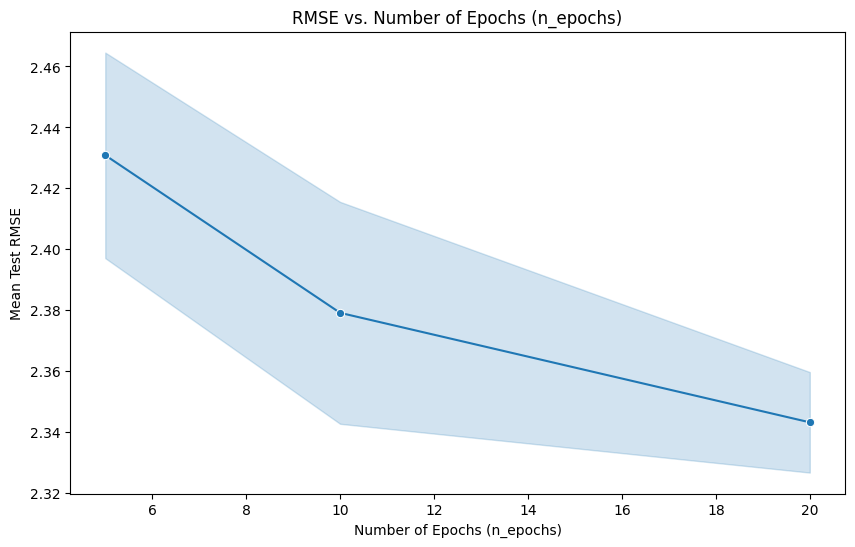

In [35]:
filtered_df = results_df[results_df['param_n_factors'] == 25]

# Creating the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='param_n_epochs', y='mean_test_rmse', marker='o')
plt.title('RMSE vs. Number of Epochs (n_epochs)')
plt.xlabel('Number of Epochs (n_epochs)')
plt.ylabel('Mean Test RMSE')
plt.show()

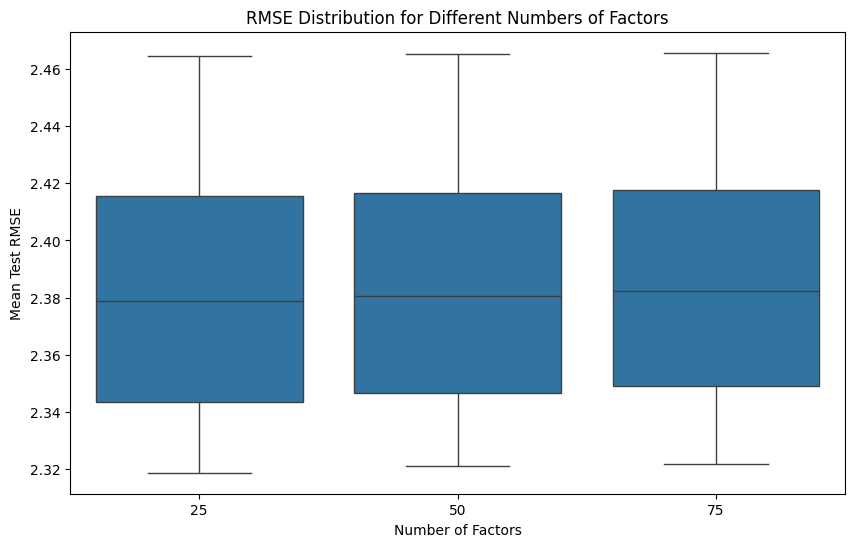

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_n_factors', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('Mean Test RMSE')
plt.show()

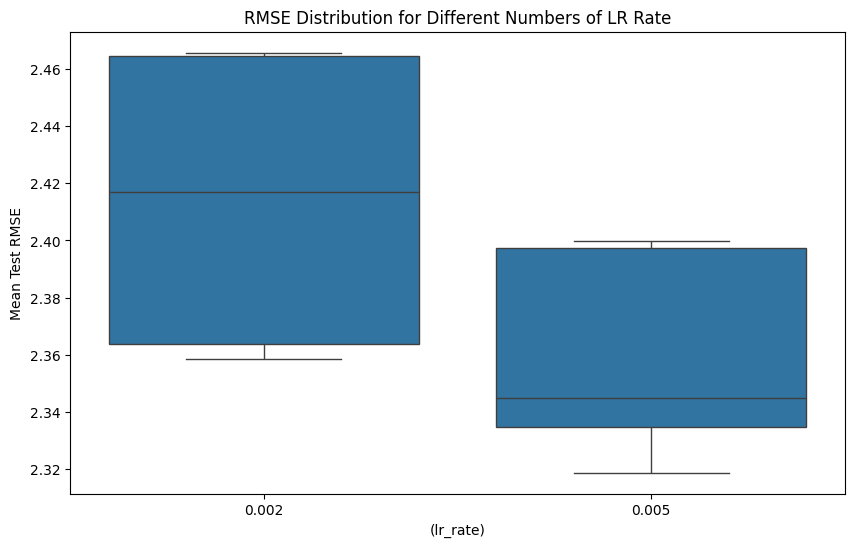

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of LR Rate')
plt.xlabel('(lr_rate)')
plt.ylabel('Mean Test RMSE')
plt.show()

## Refit our SVD with the best parameters

In [38]:
best_params = gs.best_params['rmse']
svd_model = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
svd_model.fit(trainset)

print("Evaluating SVD recomender model:\n")
# make predicitons
test_predictions = svd_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating SVD:\n")
print(f"RMSE: {rmse:.4f} ")
print(f"MAE: {mae:.4f} ")

Evaluating SVD recomender model:

RMSE: 2.3165
MAE:  1.6341
Evaluating SVD:

RMSE: 2.3165 
MAE: 1.6341 


## Evaluate our SVD against the baseline

In [43]:
print("Evaluating SVD recomender model:\n")
# make predicitons
test_predictions = svd_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating SVD vs. Baseline:\n")
print(f"RMSE: {rmse:.4f} VS. baseline: {rmse_global:.4f}")
print(f"MAE: {mae:.4f} VS. baseline: {mae_global:.4f}")

Evaluating SVD recomender model:

RMSE: 2.3165
MAE:  1.6341
Evaluating SVD vs. Baseline:

RMSE: 2.3165 VS. baseline: 2.2817
MAE: 1.6341 VS. baseline: 1.6130


# Question 1: For a random sample of 5 users with 10 or more song plays make 5 recommendations of songs they have not listened to with your SVD

## Define song prediction function

In [44]:
def get_top_n_recommendations(user_id, data, svd_model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out songs that the user has already reviewed
    listened_to_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, listened_to_songs)

    # 3. Use the model to predict the ratings for these beers
    predictions = [svd_model.predict(user_id, song).est for song in songs_to_predict]

    # 4. Combine beers and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n beers
    return song_predictions[:n]

## Sample 5 random users with 10 or more song plays

In [ ]:
user_song_plays = merged_df.groupby('user_id')['play_count'].sum().reset_index()
ten_or_more_df = user_song_plays[user_song_plays['play_count'] >=10]
ten_or_more_df.head(n=5)

In [46]:
five_random_users = ten_or_more_df.sample(n=5, random_state=52040)
five_random_users

,user_id,play_count
59058,8988342f1840417fa6b615d80e53d0d24d13a608,29
88883,cf011029308761e67f25aa93e3e8919ffd56e124,26
44707,682d4262f8b660f8050a4c7445528f68ac7a1483,43
74281,ad25b1d9765fb9d6d1004e11b973137b839db90c,266
29360,4438de355ac20883bdc4269f5e9acd243dcebeee,84


In [47]:
user_list = five_random_users['user_id'].tolist()
user_list

['8988342f1840417fa6b615d80e53d0d24d13a608',
 'cf011029308761e67f25aa93e3e8919ffd56e124',
 '682d4262f8b660f8050a4c7445528f68ac7a1483',
 'ad25b1d9765fb9d6d1004e11b973137b839db90c',
 '4438de355ac20883bdc4269f5e9acd243dcebeee']

## Find 5 songs to recommend these 5 random users

In [48]:
song_list = []

for user_id in user_list:
  top_songs = get_top_n_recommendations(user_id, data, svd_model, n=5)
  print(f"-- Top 5 Song Recommendations for user: {user_id} -- ")
  for song_name, predicted_rating in top_songs:
      print(f"{song_name}: {predicted_rating:.4f}")
  print("\n")
  for song_name in top_songs: # append to an empty list so we can store in memory
	    song_list.append(song_name)

-- Top 5 Song Recommendations for user: 8988342f1840417fa6b615d80e53d0d24d13a608 -- 
SOVWBYM12A6D4F8A22: 7.2625
SONQCXC12A6D4F6A37: 6.6849
SOIKQFR12A6310F2A6: 6.4132
SOIDMQZ12A58A7D6BF: 6.1741
SOZPMJT12AAF3B40D1: 6.1212


-- Top 5 Song Recommendations for user: cf011029308761e67f25aa93e3e8919ffd56e124 -- 
SONXUQR12AB0186C9F: 5.8418
SOZJUSJ12A8C13C249: 5.8381
SOGCGBA12AC3923C4F: 5.6161
SOXXSVC12A582A242D: 5.6074
SOANOQW12A58A793D2: 5.4899


-- Top 5 Song Recommendations for user: 682d4262f8b660f8050a4c7445528f68ac7a1483 -- 
SOJSXJY12A8C13E32E: 9.5837
SOKCXXE12A6D4F5A04: 7.0008
SOVMADB12A8C137B96: 6.8775
SOZEBAZ12AF72A80C8: 6.7406
SOKPCJJ12AB017D677: 6.7369


-- Top 5 Song Recommendations for user: ad25b1d9765fb9d6d1004e11b973137b839db90c -- 
SOUFTBI12AB0183F65: 6.7356
SOLGLUC12AB018A8FA: 6.3585
SOIMTII12A6D4F662A: 6.1056
SOIDMQZ12A58A7D6BF: 6.1021
SOCHWPT12AB0184F15: 6.0581


-- Top 5 Song Recommendations for user: 4438de355ac20883bdc4269f5e9acd243dcebeee -- 
SOJSXJY12A8C13E32E: 8.3096


In [49]:
song_list

[('SOVWBYM12A6D4F8A22', 7.26245768202271),
 ('SONQCXC12A6D4F6A37', 6.684940914324055),
 ('SOIKQFR12A6310F2A6', 6.413152768076047),
 ('SOIDMQZ12A58A7D6BF', 6.174057171347764),
 ('SOZPMJT12AAF3B40D1', 6.1212089029230405),
 ('SONXUQR12AB0186C9F', 5.841764461808781),
 ('SOZJUSJ12A8C13C249', 5.838107783859862),
 ('SOGCGBA12AC3923C4F', 5.61609642788717),
 ('SOXXSVC12A582A242D', 5.607353663540069),
 ('SOANOQW12A58A793D2', 5.4898891657823246),
 ('SOJSXJY12A8C13E32E', 9.58374854942609),
 ('SOKCXXE12A6D4F5A04', 7.000805882675052),
 ('SOVMADB12A8C137B96', 6.877521354462114),
 ('SOZEBAZ12AF72A80C8', 6.740620626892955),
 ('SOKPCJJ12AB017D677', 6.736941361526072),
 ('SOUFTBI12AB0183F65', 6.7355862927197805),
 ('SOLGLUC12AB018A8FA', 6.358524274094754),
 ('SOIMTII12A6D4F662A', 6.105604712497201),
 ('SOIDMQZ12A58A7D6BF', 6.102071750302957),
 ('SOCHWPT12AB0184F15', 6.058073807181845),
 ('SOJSXJY12A8C13E32E', 8.309560164501164),
 ('SOWYRXW12A8C1351CA', 7.5887527286178),
 ('SOTGNIO12AB0184317', 6.91331144

In [50]:
pred = pd.DataFrame(song_list, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred.head(n=25)

,song_id,play_count,track_id,artist_name,song
0,SOVWBYM12A6D4F8A22,7.262458,TRFGQNT128F146B854,The Buggles,Video Killed The Radio Star
1,SONQCXC12A6D4F6A37,6.684941,TRJWVCU128F14581FF,Sheena Easton,Strut (1993 Digital Remaster)
2,SOIKQFR12A6310F2A6,6.413153,TRJXFFX128E078234B,The Verve,Lord I Guess I'll Never Know
3,SOIDMQZ12A58A7D6BF,6.174057,TRPKSFQ128F92C6641,Gym Class Heroes,Kissin' Ears [feat. The-Dream] (Explicit Album...
4,SOZPMJT12AAF3B40D1,6.121209,TRTYOOP128F930495E,HYPOCRISY,The Quest
5,SONXUQR12AB0186C9F,5.841764,TRHGBSJ12903CC64A7,Seine,So far so long
6,SOZJUSJ12A8C13C249,5.838108,TRYASXH128F428D988,Black Oak Arkansas,Swimmin' In Quicksand (2006 Remastered LP Vers...
7,SOGCGBA12AC3923C4F,5.616096,TRFRTJV12903CE5E8B,Method Man / Ghostface Killah / Solomon Childs...,Smooth Sailing Remix
8,SOXXSVC12A582A242D,5.607354,TRTAVWJ128E078DA2A,Jake Hess,Death Ain't No Big Deal (Tribute To Jake Hess ...
9,SOANOQW12A58A793D2,5.489889,TRXRALT128F932D8F6,The fFormula,Cold Blooded (Acid Cleanse)


# Question 2: What are your top 10 recommendations for a net new user? That is a user with no user/song play count?

## Since we have no information about the new user, we should recommend songs that are popular

In [ ]:
popular_songs.head(n=10)

,song,play_count
0,You're The One,35738
1,Undo,33179
2,Revelry,24359
3,Sehr kosmisch,19454
4,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Dog Days Are Over (Radio Edit),14279
6,Secrets,12492
7,Ain't Misbehavin,11610
8,Invalid,10794
9,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


# Question 3: What are your top 10 recommendations for you and your peer?

In [ ]:
user_id = 'JACK N'
top_songs = get_top_n_recommendations(user_id, data, svd_model, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")
for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : JACK N
SOAJAFJ12A58A7B75A: 10.0000
SOAJFTU12A6701E0A3: 10.0000
SOAMNGZ12A6D4F8702: 10.0000
SOAMOYO12A6D4FD1A2: 10.0000
SOANOQW12A58A793D2: 10.0000
SOAUDET12A6D4F96B7: 10.0000
SOAZRJG12A6D4F8A30: 10.0000
SOBFCXH12A8C136D3F: 10.0000
SOBOSGD12A6D4F75C0: 10.0000
SOBOUPA12A6D4F81F1: 10.0000


## Find the song names and artists

In [ ]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_pred.head(n=10)

,song_id,play_count,track_id,artist_name,song
0,SOAJAFJ12A58A7B75A,10,TRIPLBA128F427200F,Feist,My Moon My Man
1,SOAJFTU12A6701E0A3,10,TRJUIBH128E0793AF1,The Police,O My God
2,SOAMNGZ12A6D4F8702,10,TRWCKKG12903CBEF8C,Fragma,Toca's Miracle
3,SOAMOYO12A6D4FD1A2,10,TRFZNIU128F42A6E08,Jaymen,Ooh La Lishious
4,SOANOQW12A58A793D2,10,TRXRALT128F932D8F6,The fFormula,Cold Blooded (Acid Cleanse)
5,SOAUDET12A6D4F96B7,10,TRPXXQN128F147EF6D,Keisha White,Brother
6,SOAZRJG12A6D4F8A30,10,TRCXRWD128E0782C18,Ella Fitzgerald,On Green Dolphin Street (Medley) (1999 Digital...
7,SOBFCXH12A8C136D3F,10,TRJFTBY12903CEA792,Griffin House,The Guy That Says Goodbye To You Is Out Of His...
8,SOBOSGD12A6D4F75C0,10,TRSDHFX128F145464E,Rachid Taha,Kelma
9,SOBOUPA12A6D4F81F1,10,TRMGUWH128F146903A,Alliance Ethnik,Sincerité Et Jalousie
